In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import LinearRegression
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map
sys.path.append('..')
from utils.data import Subject, load_participant_list

In [3]:
base_dir = '/Users/hugofluhr/data/LH_dev'
bids_dir = "/Users/hugofluhr/data/LH_dev/fmriprep-23.2.1"

sub_ids = load_participant_list(base_dir)
sub_ids = sub_ids

In [4]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]

/Users/hugofluhr/phd_local/repositories/RewardPairsTask_Analysis/notebooks/../utils/data.py:166: UserWarning: Last 1 trial(s) of block had no response, filling with 0


# Setting parameters

In [5]:
tr = 2.33384
hrf_model = 'spm'
noise_model = 'ar1'
smoothing_fwhm = 5
high_pass = 0.01
motion_type = 'basic'

run = 'test'

# Get the data

In [6]:
# ref to the block
blocks = [getattr(subject, run) for subject in subjects]
events_list = [block.events for block in blocks]

In [7]:
img_paths = [subject.img.get(run) for subject in subjects]
fmri_imgs = [image.load_img(img_path) for img_path in img_paths]

In [8]:
confounds, sample_mask  = zip(*[subject.load_confounds(run, motion_type=motion_type) for subject in subjects])

# First Level Models

In [9]:
n = fmri_imgs[0].shape[-1]
frametimes = np.linspace(tr/2., (n - .5)*tr, n) # from Gilles, checked with nilearn FirstLevelModel

In [10]:
# Ignore warnings related to null duration events and unexpected columns in events data
warnings.filterwarnings("ignore", message=".*events with null duration.*")
warnings.filterwarnings("ignore", message=".*following unexpected columns in events data.*")

X1s = [make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)
        for events, confounds in zip(events_list, confounds)]

In [11]:
models = [FirstLevelModel(smoothing_fwhm=smoothing_fwhm) for _ in subjects]
model_fits = [model.fit(fmri_img, design_matrices=X1, sample_masks=sample_mask)
              for model, fmri_img, X1, sample_mask in zip(models, fmri_imgs, X1s, sample_mask)]

In [12]:
z_maps_response = [model_fit.compute_contrast('response', output_type='z_score')
                   for model_fit in model_fits]

In [13]:
z_maps_first_stim = [model_fit.compute_contrast('first_stim_presentation', output_type='z_score')
                   for model_fit in model_fits]

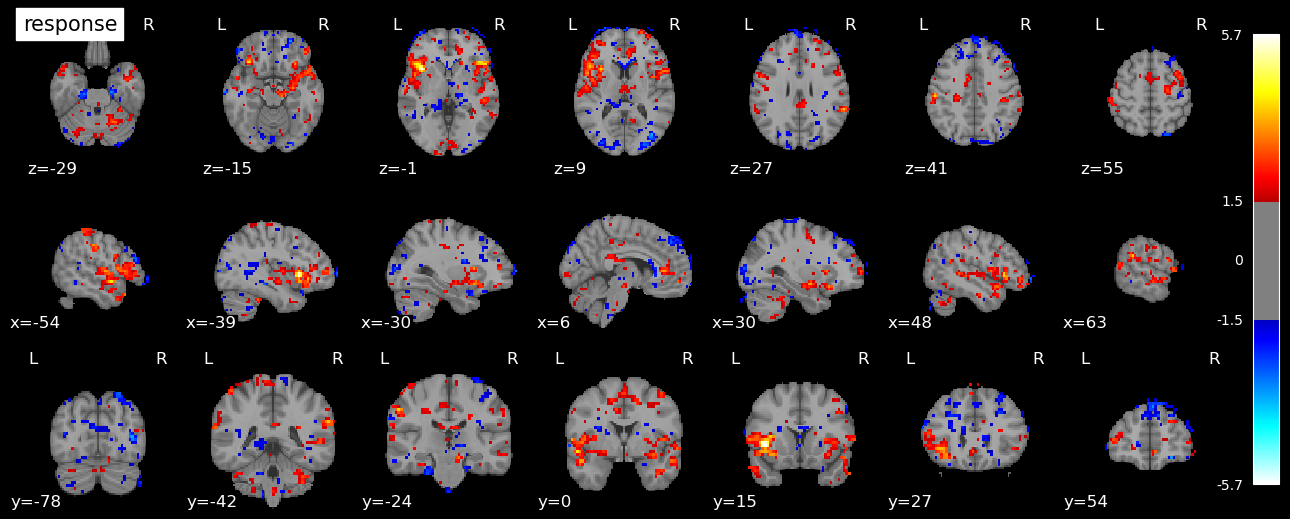

In [14]:
# plot an example z-map
plot_stat_map(z_maps_response[0], threshold=1.5, display_mode='mosaic', black_bg=True, title='response')

# Second level - Button press

In [15]:
X_response = pd.DataFrame([1] * len(z_maps_response), columns=['Intercept'])

In [16]:
model2 = SecondLevelModel()
model2 = model2.fit(z_maps_response, design_matrix=X_response)

In [17]:
X_response

,Intercept
0,1
1,1
2,1
3,1
4,1
...,...
57,1
58,1
59,1
60,1


In [18]:
response_map = model2.compute_contrast('Intercept',output_type='z_score')

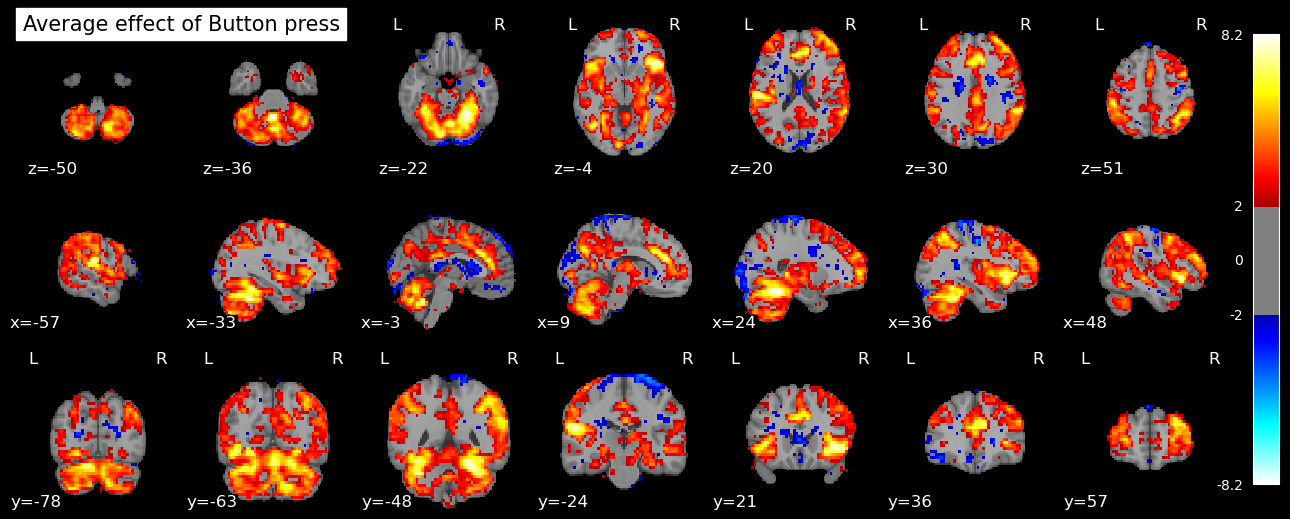

In [19]:
plot_stat_map(response_map, threshold=2, black_bg=True, display_mode='mosaic', title='Average effect of Button press')

In [25]:
thresholded_zmap, threshold = threshold_stats_img(response_map, alpha=0.05, height_control='bonferroni')#, cluster_threshold=30)
print(f"RL whole brain Bonferroni threshold: {threshold:.3f}")

RL whole brain Bonferroni threshold: 4.955


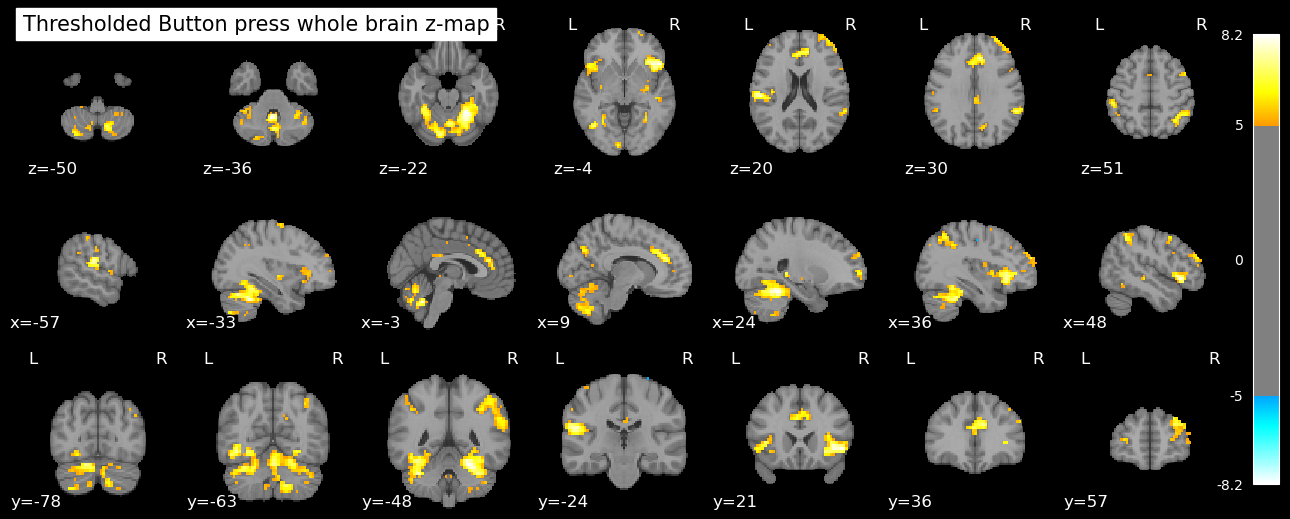

In [27]:
plot_stat_map(response_map, threshold=threshold, black_bg=True, display_mode='mosaic', title='Thresholded Button press whole brain z-map')

# Second level - First Stimulus presentation

In [28]:
X_response = pd.DataFrame([1] * len(z_maps_first_stim), columns=['Intercept'])

In [29]:
model3 = SecondLevelModel()
model3 = model3.fit(z_maps_first_stim, design_matrix=X_response)

In [30]:
first_stim_map = model3.compute_contrast('Intercept',output_type='z_score')

In [31]:
_ , threshold_first_stim = threshold_stats_img(first_stim_map, alpha=0.05, height_control='bonferroni')#, cluster_threshold=30)
print(f"RL whole brain Bonferroni threshold: {threshold_first_stim:.3f}")

RL whole brain Bonferroni threshold: 4.955


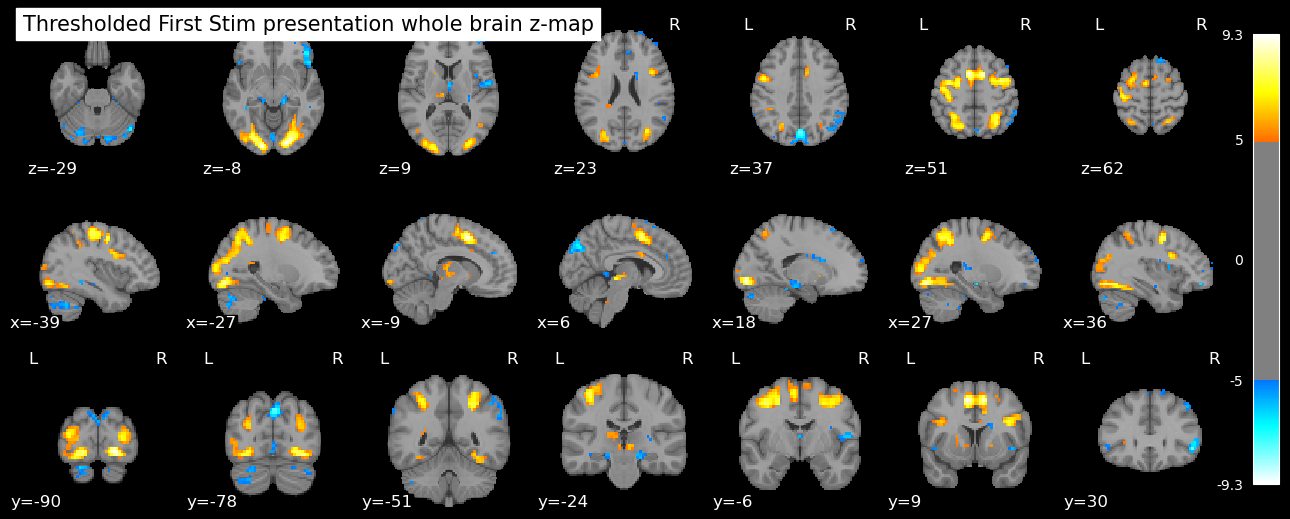

In [32]:
plot_stat_map(first_stim_map, threshold=threshold_first_stim, black_bg=True, display_mode='mosaic', title='Thresholded First Stim presentation whole brain z-map')